# Project price cars prediction


In [484]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt

In [485]:
cars = pd.read_csv('data.csv')
cars = cars.iloc[:, 1:]

In [486]:
cars.shape

(251079, 14)

In [487]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251079 entries, 0 to 251078
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   brand                     251079 non-null  object 
 1   model                     251079 non-null  object 
 2   color                     250913 non-null  object 
 3   registration_date         251075 non-null  object 
 4   year                      251079 non-null  object 
 5   price_in_euro             251079 non-null  object 
 6   power_kw                  250945 non-null  object 
 7   power_ps                  250950 non-null  object 
 8   transmission_type         251079 non-null  object 
 9   fuel_type                 251079 non-null  object 
 10  fuel_consumption_l_100km  224206 non-null  object 
 11  fuel_consumption_g_km     251079 non-null  object 
 12  mileage_in_km             250927 non-null  float64
 13  offer_description         251078 non-null  o

In [488]:
#setting columns into numeric
cars['price_in_euro'] = pd.to_numeric(cars['price_in_euro'], errors='coerce')
cars['power_kw'] = pd.to_numeric(cars['power_kw'], errors='coerce')
cars['power_ps'] = pd.to_numeric(cars['power_ps'], errors='coerce')

In [489]:
#cleaning and setting datetime for *registration_date* and *year*
cars = cars[cars['registration_date'].str.match(r'^(0[1-9]|1[0-2])/[0-9]{4}$', na=False)]
cars['registration_date'] = pd.to_datetime(cars['registration_date'], format='%m/%Y')
cars['registration_date'].value_counts()

cars['year'] = pd.to_datetime(cars['year'], format='%Y')

In [490]:
#drop missing values
cars = cars.dropna(subset=['color'])

cars = cars.dropna(subset=['power_kw']) #delete also for power_ps because they have the same missing values

cars = cars.dropna(subset=['fuel_consumption_l_100km'])

cars = cars.dropna(subset=['mileage_in_km'])

In [491]:
cars['transmission_type'].value_counts() #à voir si on supprime les lignes avec unknown

transmission_type
Automatic         114123
Manual            108557
Unknown              770
Semi-automatic       283
Name: count, dtype: int64

In [492]:
cars['fuel_type'].value_counts() #à voir si on supprime les lignes avec other et unknown

fuel_type
Petrol           132026
Diesel            78928
Hybrid            10312
LPG                1054
Electric            471
CNG                 414
Diesel Hybrid       375
Other                87
Hydrogen             38
Unknown              23
Ethanol               5
Name: count, dtype: int64

In [493]:
#cleaning and setting float for *fuel_consumption_l_100km*
cars = cars[cars['fuel_consumption_l_100km'].str.contains('l/100 km', na=False)]

cars['fuel_consumption_l_100km'] = cars['fuel_consumption_l_100km'].str.extract(r'([\d,]+)')
cars['fuel_consumption_l_100km'] = cars['fuel_consumption_l_100km'].astype(str).str.replace(',', '.', regex=False)

cars['fuel_consumption_l_100km'] = pd.to_numeric(cars['fuel_consumption_l_100km'], errors='coerce')

In [494]:
#cleaning and setting float for *fuel_consumption_g_km*
cars = cars[cars['fuel_consumption_g_km'].str.contains('g/km', na=False)] 
cars['fuel_consumption_g_km'] = cars['fuel_consumption_g_km'].astype(str).str.replace(',', '.', regex=False)

cars['fuel_consumption_g_km'] = cars['fuel_consumption_g_km'].str.extract(r'([\d,]+)')

cars['fuel_consumption_g_km'] = pd.to_numeric(cars['fuel_consumption_g_km'], errors='coerce')
cars['fuel_consumption_g_km'] = cars['fuel_consumption_g_km'].replace(0, np.nan)

cars = cars.dropna(subset=['fuel_consumption_g_km'])

In [495]:
#shape and info after cleaning
print(cars.shape)
print(cars.info())

(198494, 14)
<class 'pandas.core.frame.DataFrame'>
Index: 198494 entries, 0 to 251076
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   brand                     198494 non-null  object        
 1   model                     198494 non-null  object        
 2   color                     198494 non-null  object        
 3   registration_date         198494 non-null  datetime64[ns]
 4   year                      198494 non-null  datetime64[ns]
 5   price_in_euro             198494 non-null  float64       
 6   power_kw                  198494 non-null  float64       
 7   power_ps                  198494 non-null  float64       
 8   transmission_type         198494 non-null  object        
 9   fuel_type                 198494 non-null  object        
 10  fuel_consumption_l_100km  198494 non-null  float64       
 11  fuel_consumption_g_km     198494 non-null  float64       

In [496]:
cars.describe()

,registration_date,year,price_in_euro,power_kw,power_ps,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km
count,198494,198494,1.984940e+05,198494.000000,198494.000000,198494.000000,198494.000000,1.984940e+05
mean,2017-01-10 06:07:42.482492928,2016-08-04 15:31:22.249337600,2.606340e+04,124.312876,169.100487,6.143275,146.036651,8.185130e+04
min,1995-01-01 00:00:00,1995-01-01 00:00:00,1.490000e+02,10.000000,14.000000,0.000000,1.000000,0.000000e+00
25%,2014-05-01 00:00:00,2014-01-01 00:00:00,1.249000e+04,81.000000,110.000000,4.900000,119.000000,2.315200e+04
50%,2018-05-01 00:00:00,2018-01-01 00:00:00,1.999000e+04,110.000000,150.000000,5.700000,137.000000,6.500000e+04
75%,2020-11-01 00:00:00,2020-01-01 00:00:00,2.995000e+04,140.000000,190.000000,6.700000,163.000000,1.212000e+05
max,2023-07-01 00:00:00,2023-01-01 00:00:00,5.890500e+06,735.000000,999.000000,173.000000,999.000000,3.800000e+06
std,NaN,NaN,3.594448e+04,69.679897,94.710872,3.950388,46.284878,7.609831e+04


In [497]:
cars.isnull().sum()

brand                       0
model                       0
color                       0
registration_date           0
year                        0
price_in_euro               0
power_kw                    0
power_ps                    0
transmission_type           0
fuel_type                   0
fuel_consumption_l_100km    0
fuel_consumption_g_km       0
mileage_in_km               0
offer_description           0
dtype: int64

In [498]:
cars.duplicated().sum()


5858

<Axes: >

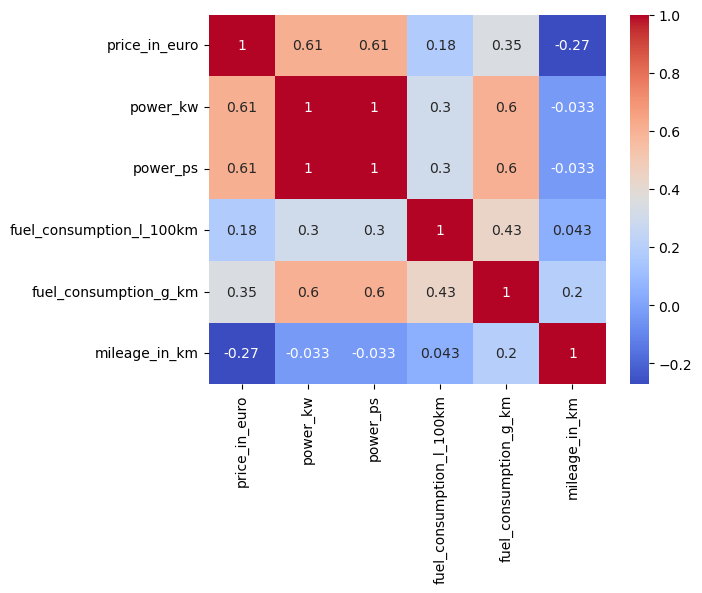

In [499]:
sns.heatmap(cars.corr(numeric_only=True), annot=True, cmap='coolwarm')

In [500]:
#drop of power_ps because same as power_kw 
cars.drop('power_ps', axis=1,inplace=True)

In [501]:
cars.reset_index(drop=True,inplace=True)
cars.head(10)

,brand,model,color,registration_date,year,price_in_euro,power_kw,transmission_type,fuel_type,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km,offer_description
0,alfa-romeo,Alfa Romeo GTV,red,1995-10-01,1995-01-01,1300.0,148.0,Manual,Petrol,10.9,260.0,160500.0,2.0 V6 TB
1,alfa-romeo,Alfa Romeo Spider,black,1995-07-01,1995-01-01,4900.0,110.0,Manual,Petrol,9.5,225.0,189500.0,2.0 16V Twin Spark L
2,alfa-romeo,Alfa Romeo Spider,red,1996-04-01,1996-01-01,7900.0,110.0,Manual,Petrol,9.5,225.0,47307.0,2.0 16V Twin Spark
3,alfa-romeo,Alfa Romeo 145,red,1996-12-01,1996-01-01,3500.0,110.0,Manual,Petrol,8.8,210.0,230000.0,Quadrifoglio
4,alfa-romeo,Alfa Romeo 164,black,1996-07-01,1996-01-01,5500.0,132.0,Manual,Petrol,13.4,320.0,168000.0,(3.0) V6 Super
5,alfa-romeo,Alfa Romeo Spider,black,1996-07-01,1996-01-01,8990.0,141.0,Manual,Petrol,11.0,265.0,168600.0,|HU:neu|Klimaanlage|Youngtimer|
6,alfa-romeo,Alfa Romeo Spider,black,1996-01-01,1996-01-01,6976.0,110.0,Manual,Petrol,9.2,220.0,99000.0,2.0 T.Spark L *Klima *2.Hand *Zahnriemen
7,alfa-romeo,Alfa Romeo Spider,silver,1996-02-01,1996-01-01,5499.0,141.0,Manual,Petrol,11.1,265.0,157000.0,3.0 V6 L
8,alfa-romeo,Alfa Romeo Spider,silver,1996-10-01,1996-01-01,8499.0,110.0,Manual,Petrol,9.5,225.0,15550.0,2.0 spider
9,alfa-romeo,Alfa Romeo GTV,grey,1997-05-01,1997-01-01,15800.0,162.0,Manual,Petrol,11.7,125.0,177000.0,3.0 V6 24v


array([[<Axes: title={'center': 'registration_date'}>,
        <Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'price_in_euro'}>],
       [<Axes: title={'center': 'power_kw'}>,
        <Axes: title={'center': 'fuel_consumption_l_100km'}>,
        <Axes: title={'center': 'fuel_consumption_g_km'}>],
       [<Axes: title={'center': 'mileage_in_km'}>, <Axes: >, <Axes: >]],
      dtype=object)

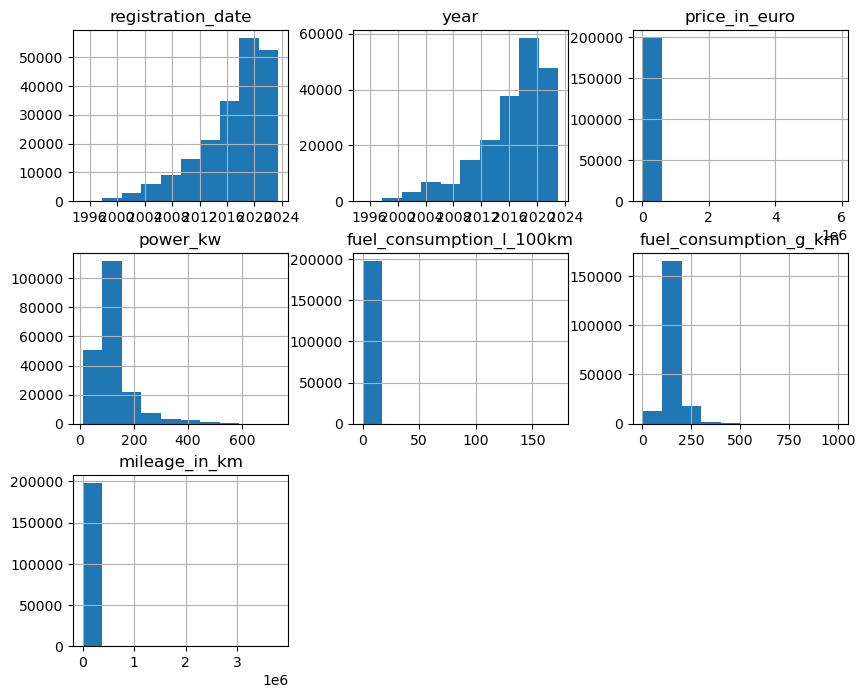

In [502]:
cars.hist(figsize=(10,8))

<Axes: xlabel='year'>

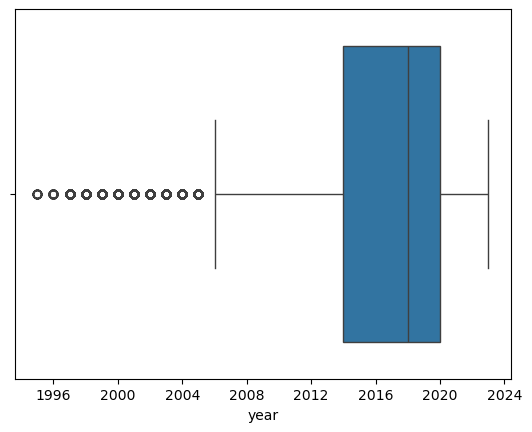

In [503]:
sns.boxplot(data=cars, x='year')

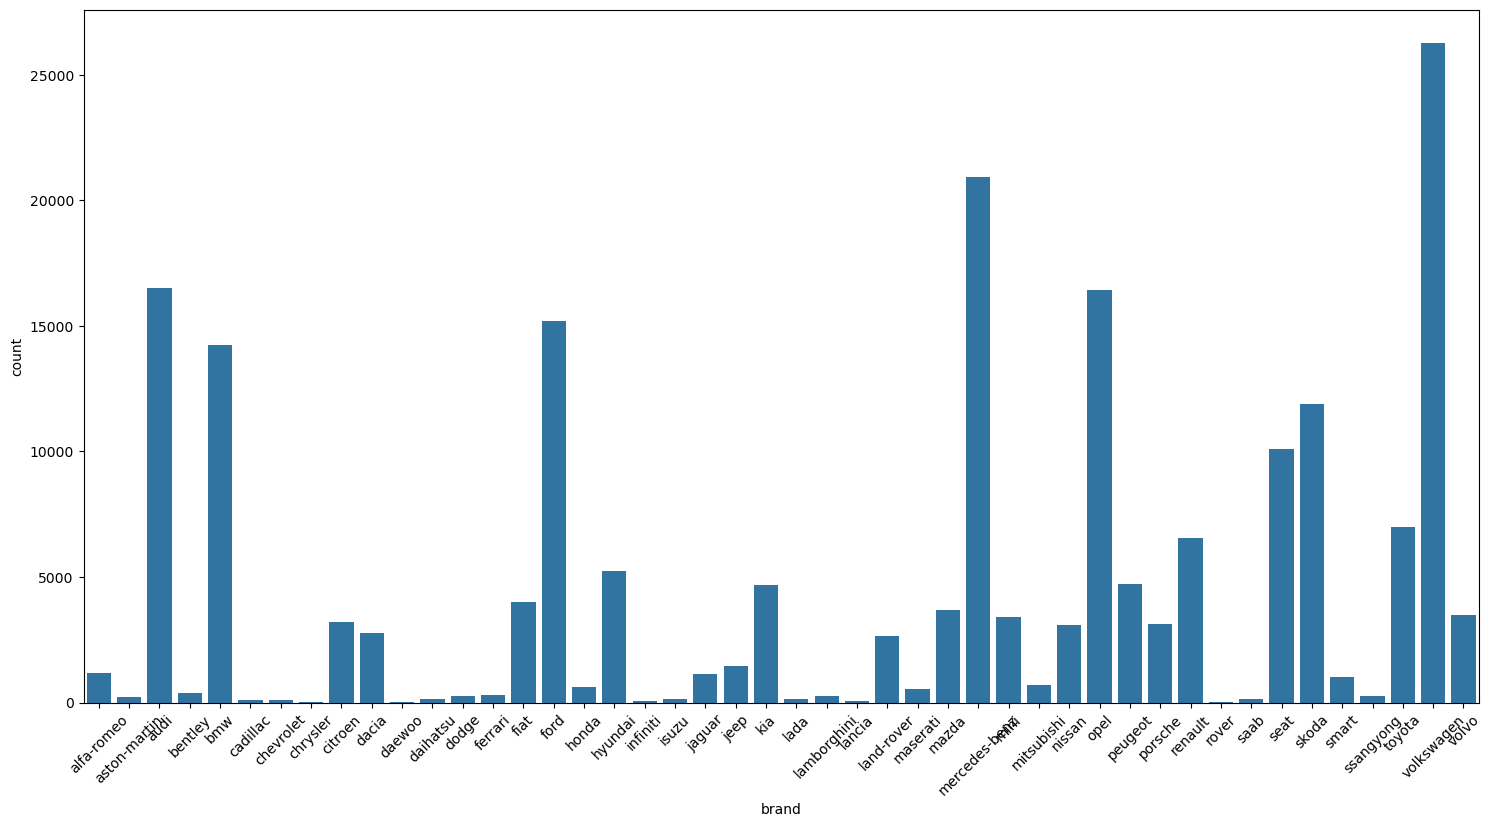

In [504]:
#noumber of cars per brand
plt.figure(figsize=(18,9))  
sns.countplot(data=cars, x='brand')
plt.xticks(rotation=45)
plt.show()

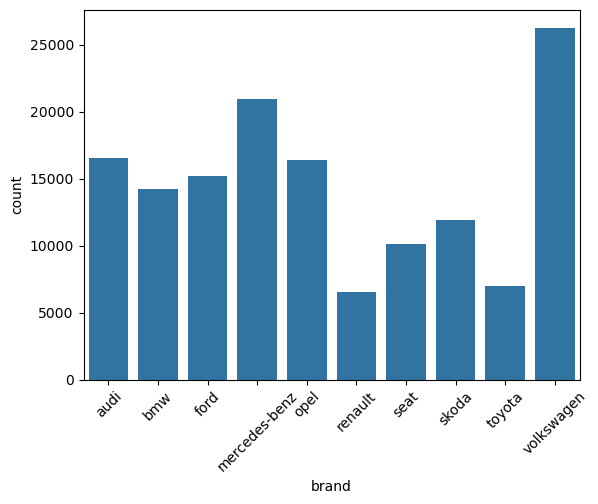

In [505]:
#top 10 most present brands
top_brands = cars['brand'].value_counts().nlargest(10).index
sns.countplot(data=cars[cars['brand'].isin(top_brands)], x='brand')
plt.xticks(rotation=45)
plt.show()